In [1]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0

from tensorflow.keras import Model
#from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Limit GPU Memory Growth to only what's needed
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Failed to limit GPU memory')

In [3]:
#Gather Pre-proccessed images 

train_path = 'dataset-classification/train-segmented'
valid_path = 'dataset-classification/validate-segmented'

train_generator = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256))
valid_generator = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256))

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [4]:
#Build Model 

base_model = EfficientNetV2B0(weights='imagenet', include_top = False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs = preds)

In [5]:
#model.summary()

In [6]:
for layers in model.layers[:-25]:
    layers.trainable = False
    

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                            

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   768        ['block3b_expand_conv[0][0]']    
 ization)                       192)                                                              
                                                                                                  
 block3b_expand_activation (Act  (None, None, None,   0          ['block3b_expand_bn[0][0]']      
 ivation)                       192)                                                              
                                                                                                  
 block3b_project_conv (Conv2D)  (None, None, None,   9216        ['block3b_expand_activation[0][0]
                                48)                              ']                               
                                                                                                  
 block3b_p

                                384)                              'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, None, None,   36864       ['block4b_se_excite[0][0]']      
                                96)                                                               
                                                                                                  
 block4b_project_bn (BatchNorma  (None, None, None,   384        ['block4b_project_conv[0][0]']   
 lization)                      96)                                                               
                                                                                                  
 block4b_drop (Dropout)         (None, None, None,   0           ['block4b_project_bn[0][0]']     
                                96)                                                               
          

 block5a_se_excite (Multiply)   (None, None, None,   0           ['block5a_activation[0][0]',     
                                576)                              'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, None, None,   64512       ['block5a_se_excite[0][0]']      
                                112)                                                              
                                                                                                  
 block5a_project_bn (BatchNorma  (None, None, None,   448        ['block5a_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, None, None,   75264       ['block5a_project_bn[0][0]']     
          

                                                                                                  
 block5c_project_bn (BatchNorma  (None, None, None,   448        ['block5c_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5c_drop (Dropout)         (None, None, None,   0           ['block5c_project_bn[0][0]']     
                                112)                                                              
                                                                                                  
 block5c_add (Add)              (None, None, None,   0           ['block5c_drop[0][0]',           
                                112)                              'block5b_add[0][0]']            
                                                                                                  
 block5d_e

                                112)                                                              
                                                                                                  
 block5e_project_bn (BatchNorma  (None, None, None,   448        ['block5e_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5e_drop (Dropout)         (None, None, None,   0           ['block5e_project_bn[0][0]']     
                                112)                                                              
                                                                                                  
 block5e_add (Add)              (None, None, None,   0           ['block5e_drop[0][0]',           
                                112)                              'block5d_add[0][0]']            
          

 block6b_drop (Dropout)         (None, None, None,   0           ['block6b_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6b_add (Add)              (None, None, None,   0           ['block6b_drop[0][0]',           
                                192)                              'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, None, None,   221184      ['block6b_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, None, None,   4608       ['block6c_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block6d_drop (Dropout)         (None, None, None,   0           ['block6d_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6d_add (Add)              (None, None, None,   0           ['block6d_drop[0][0]',           
                                192)                              'block6c_add[0][0]']            
                                                                                                  
 block6e_expand_conv (Conv2D)   (None, None, None,   221184      ['block6d_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6e_e

 lization)                      192)                                                              
                                                                                                  
 block6f_drop (Dropout)         (None, None, None,   0           ['block6f_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6f_add (Add)              (None, None, None,   0           ['block6f_drop[0][0]',           
                                192)                              'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, None, None,   221184      ['block6f_add[0][0]']            
                                1152)                                                             
          

 block6h_project_bn (BatchNorma  (None, None, None,   768        ['block6h_project_conv[0][0]']   
 lization)                      192)                                                              
                                                                                                  
 block6h_drop (Dropout)         (None, None, None,   0           ['block6h_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6h_add (Add)              (None, None, None,   0           ['block6h_drop[0][0]',           
                                192)                              'block6g_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, None, None,   245760      ['block6h_add[0][0]']            
          

In [8]:
epochs = 30

optimizer = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs = epochs, verbose=2)

Epoch 1/30
75/75 - 34s - loss: 0.6848 - accuracy: 0.7487 - val_loss: 0.4201 - val_accuracy: 0.8400 - 34s/epoch - 447ms/step
Epoch 2/30
75/75 - 20s - loss: 0.2781 - accuracy: 0.9062 - val_loss: 0.2316 - val_accuracy: 0.9067 - 20s/epoch - 261ms/step
Epoch 3/30
75/75 - 20s - loss: 0.1775 - accuracy: 0.9375 - val_loss: 0.2289 - val_accuracy: 0.9133 - 20s/epoch - 268ms/step
Epoch 4/30
75/75 - 20s - loss: 0.1141 - accuracy: 0.9588 - val_loss: 0.1194 - val_accuracy: 0.9633 - 20s/epoch - 270ms/step
Epoch 5/30
75/75 - 20s - loss: 0.0924 - accuracy: 0.9696 - val_loss: 0.1060 - val_accuracy: 0.9567 - 20s/epoch - 269ms/step
Epoch 6/30
75/75 - 20s - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.0999 - val_accuracy: 0.9633 - 20s/epoch - 269ms/step
Epoch 7/30
75/75 - 20s - loss: 0.0643 - accuracy: 0.9775 - val_loss: 0.1165 - val_accuracy: 0.9600 - 20s/epoch - 267ms/step
Epoch 8/30
75/75 - 20s - loss: 0.0570 - accuracy: 0.9812 - val_loss: 0.0760 - val_accuracy: 0.9733 - 20s/epoch - 267ms/step
Epoch 9/

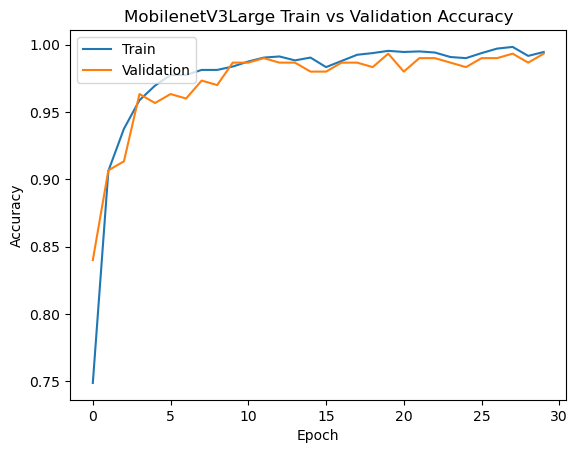

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobilenetV3Large Train vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

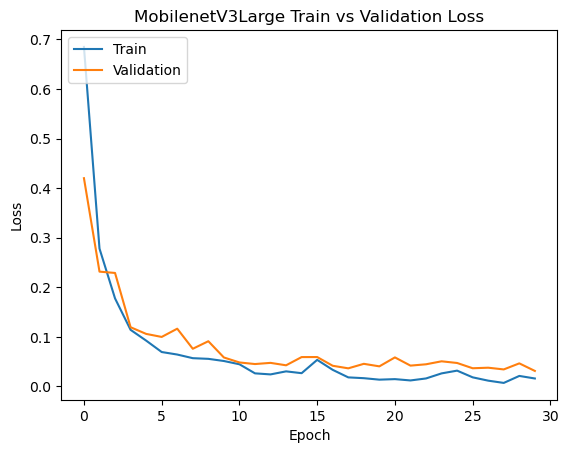

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobilenetV3Large Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [11]:
test_path = 'dataset-classification/test-segmented'
test_generator = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256))
predictions = model.predict(x = test_generator, verbose = 0)

Found 300 images belonging to 3 classes.


In [12]:
test_labels = test_generator.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
test_generator.class_indices

{'-K': 0, '-N': 1, 'FN': 2}

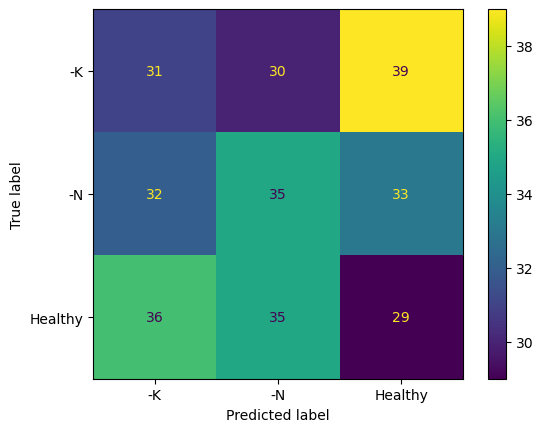

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-K', '-N', 'Healthy'])
disp.plot()
plt.show()

In [14]:
from sklearn.metrics import classification_report 

print(classification_report(test_labels,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.31      0.31      0.31       100
           1       0.35      0.35      0.35       100
           2       0.29      0.29      0.29       100

    accuracy                           0.32       300
   macro avg       0.32      0.32      0.32       300
weighted avg       0.32      0.32      0.32       300



In [15]:
#model.save("EfficientNetB0.h5")